In [1]:
!git clone https://github.com/BindsNET/bindsnet.git
%cd bindsnet

Cloning into 'bindsnet'...
remote: Enumerating objects: 11643, done.
remote: Counting objects: 100% (1780/1780), done.
remote: Compressing objects: 100% (295/295), done.
remote: Total 11643 (delta 1613), reused 1552 (delta 1480), pack-reused 9863 (from 3)
Receiving objects: 100% (11643/11643), 62.47 MiB | 16.54 MiB/s, done.
Resolving deltas: 100% (7255/7255), done.
/content/bindsnet


In [2]:
!pip install -e .
!pip install torchvision matplotlib numpy

Obtaining file:///content/bindsnet
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 101.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1


Training on MNIST
Accuracy on mnist: 0.8601

Training on FASHION
Accuracy on fashion: 0.7742

Training on CIFAR10
Accuracy on cifar10: 0.2270


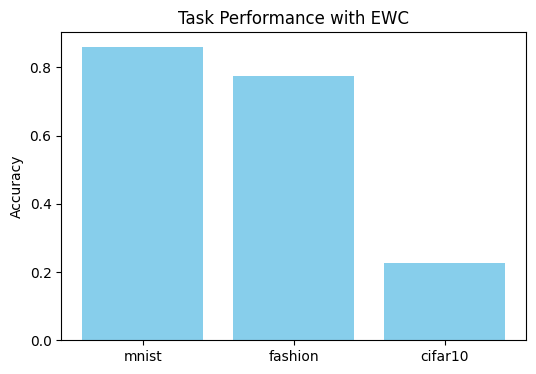

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 1. Simple MLP Model (acts as stand-in for SNN concept)
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 2. Dataset Loader
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((28, 28)),                  # Resize to 28x28
    transforms.ToTensor()
])

def get_dataset(name, batch_size=64):
    if name == "mnist":
        dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
    elif name == "fashion":
        dataset = datasets.FashionMNIST(root="data", train=True, download=True, transform=transform)
    elif name == "cifar10":
        dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
    else:
        raise ValueError("Unknown dataset")
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


# 3. EWC Implementation
class EWC:
    def __init__(self, model, dataloader, device='cpu'):
        self.model = model
        self.device = device
        self.params = {n: p.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}
        self.fisher = self._compute_fisher(dataloader)

    def _compute_fisher(self, dataloader):
        fisher = {n: torch.zeros_like(p, device=self.device) for n, p in self.params.items()}
        self.model.eval()
        for data, target in dataloader:
            data, target = data.to(self.device), target.to(self.device)
            self.model.zero_grad()
            output = self.model(data)
            loss = torch.nn.functional.cross_entropy(output, target)
            loss.backward()
            for n, p in self.model.named_parameters():
                if p.grad is not None:
                    fisher[n] += p.grad.data ** 2
        for n in fisher:
            fisher[n] /= len(dataloader)
        return fisher

    def penalty(self, model):
        loss = 0
        for n, p in model.named_parameters():
            if n in self.params:
                loss += (self.fisher[n] * (p - self.params[n]) ** 2).sum()
        return loss

# 4. Training and Evaluation
def train_model(model, dataloader, optimizer, ewc=None, lambda_ewc=0.4):
    model.train()
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.cross_entropy(output, target)
        if ewc:
            loss += lambda_ewc * ewc.penalty(model)
        loss.backward()
        optimizer.step()

def evaluate_model(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
    return correct / total

# 5. Run Experiment
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimpleMLP().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
tasks = ["mnist", "fashion", "cifar10"]
old_ewc = None
results = {}

for task in tasks:
    print(f"\nTraining on {task.upper()}")
    dataloader = get_dataset(task)
    train_model(model, dataloader, optimizer, ewc=old_ewc)
    acc = evaluate_model(model, dataloader)
    results[task] = acc
    old_ewc = EWC(model, dataloader)
    print(f"Accuracy on {task}: {acc:.4f}")

# 6. Plot results
plt.figure(figsize=(6,4))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.ylabel("Accuracy")
plt.title("Task Performance with EWC")
plt.show()
